## Sentiment analysis on the NoReC dataset, using support vector machine

In [2]:
import pandas as pd
import numpy as np
import csv
import re
import pickle
import time

# Run these if you cannot import the nltk libs.
#import nltk
#nltk.download('stopwords')
#nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import SVC

import matplotlib.pyplot as plt

### Load in data

In [8]:
articles = pd.read_csv('data/data.csv', encoding='utf-8')

# articles['content_split'] = articles.loc[:, 'content'].apply(lambda x: x.split())
articles['sentiment'] = [(1 if rating > 3 else 0) for rating in articles.loc[:, 'rating']]
articles['three_sentiment'] = [(1 if rating > 4 else 0 if rating < 3 else 2) for rating in articles.loc[:, 'rating']]

In [9]:
print(len(articles), 'records')
articles.head()

43614 records


,category,cons,language,pros,rating,source,source-category,source-tags,split,tags,content,sentiment,three_sentiment
0,screen,NaN,nb,NaN,6,p3,tv,[],train,['tv'],rom s topp inn tvdram akkurat ! andr sist seso...,1,1
1,screen,NaN,nb,NaN,6,p3,tv,[],train,['tv'],twin peaks definitiv gold box edition gull twi...,1,1
2,screen,NaN,nb,NaN,6,p3,tv,[],train,['tv'],the wir sesong the wir gjør avheng god måt nes...,1,1
3,screen,NaN,nb,NaN,5,p3,tv,[],train,['tv'],mad sesong stil underhold sofistiker ! tvseri ...,1,1
4,screen,NaN,nb,NaN,5,p3,film,[],train,['movie'],mad sesong tvunderholdning høyest kvalit ! før...,1,1


### Split data into training and test datasets

In [10]:
tf_idf_cv = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = True)
review_content_tf = tf_idf_cv.fit_transform(articles.content)

trainX, testX, trainY, testY = train_test_split(review_content_tf, articles.sentiment, test_size = 0.2, random_state = 1)

crossval = KFold(n_splits = 5, shuffle = True, random_state = 1)

### Using best model params from support_vector_machine.ipynb

In [6]:
svc_score = []
svc = SVC(gamma = "auto", kernel = "linear")

print("Starting cross-validation")
for train_idx, value_idx in crossval.split(trainX):
    x_train, x_val = review_content_tf[train_idx], review_content_tf[value_idx]
    y_train, y_val = articles.sentiment[train_idx], articles.sentiment[value_idx]
    svc.fit(x_train, y_train)
    svc_score.append(svc.score(x_val, y_val))
    print("Completed a cross-validation iteration")

print("Model Predictions: ", accuracy_score(svc.predict(testX), testY))
print("Validation_score: ", np.mean(svc_score))

Starting cross-validation
Completed a cross-validation iteration
Completed a cross-validation iteration
Completed a cross-validation iteration
Completed a cross-validation iteration
Completed a cross-validation iteration
Model Predictions:  0.9251404333371547
Validation_score:  0.8519674981214372


### Validation Curve
#### Tolerance

In [7]:
SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [5]:
param_range = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
train_scores, test_scores = validation_curve(
    SVC(gamma="auto", kernel="linear"), review_content_tf, articles.sentiment, 
    param_name="tol", param_range = param_range, scoring="accuracy", cv = 5, n_jobs = 6, verbose = 5)

train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)

test_scores_mean = np.mean(test_scores, axis = 1)
test_scores_std = np.std(test_scores, axis = 1)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   4 out of  35 | elapsed: 63.7min remaining: 493.5min
[Parallel(n_jobs=6)]: Done  12 out of  35 | elapsed: 133.3min remaining: 255.4min
[Parallel(n_jobs=6)]: Done  20 out of  35 | elapsed: 227.4min remaining: 170.6min
[Parallel(n_jobs=6)]: Done  28 out of  35 | elapsed: 294.5min remaining: 73.6min
[Parallel(n_jobs=6)]: Done  35 out of  35 | elapsed: 360.1min finished


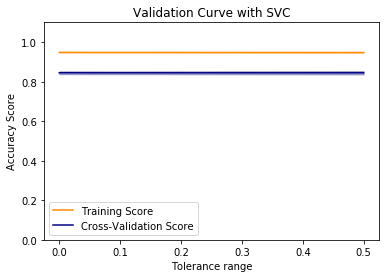

In [6]:
plt.title("Validation Curve with SVC")
plt.xlabel("Tolerance range")
plt.ylabel("Accuracy Score")
plt.ylim(0.0, 1.1)

plt.plot(param_range, train_scores_mean, label = "Training Score", color = "darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha = 0.3, color = "darkorange")
plt.plot(param_range, test_scores_mean, label = "Cross-Validation Score", color = "navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha = 0.3, color = "navy")

plt.legend(loc="best")
plt.Figure(figsize=(15, 15))
plt.show()


#### max_iter

In [11]:
param_range = [1, 10, 25, 50, 100, 250, 500, 1000, 1500, 2000, 2500]
train_scores, test_scores = validation_curve(
    SVC(gamma="auto", kernel="linear"), review_content_tf, articles.sentiment, 
    param_name="max_iter", param_range = param_range, scoring="accuracy", cv = 5, n_jobs = 6, verbose = 5)

train_scores_mean = np.mean(train_scores, axis = 1)
train_scores_std = np.std(train_scores, axis = 1)

test_scores_mean = np.mean(test_scores, axis = 1)
test_scores_std = np.std(test_scores, axis = 1)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   8 out of  55 | elapsed:  1.2min remaining:  7.3min
[Parallel(n_jobs=6)]: Done  20 out of  55 | elapsed:  8.7min remaining: 15.2min
C:\Users\stian\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=6)]: Done  32 out of  55 | elapsed: 14.9min remaining: 10.7min
[Parallel(n_jobs=6)]: Done  44 out of  55 | elapsed: 20.7min remaining:  5.2min
[Parallel(n_jobs=6)]: Done  55 out of  55 | elapsed: 34.2min finished


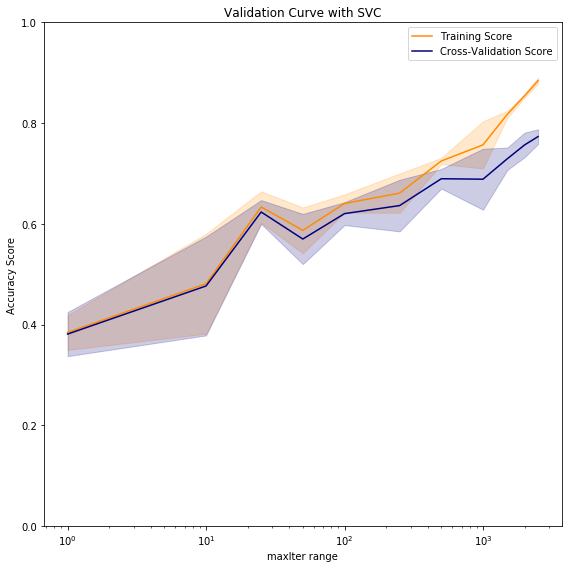

In [33]:
plt.title("Validation Curve with SVC")
plt.xlabel("maxIter range")
plt.ylabel("Accuracy Score")
plt.ylim(0.0, 1.0)
plt.xscale('log',basex=10) 

plt.plot(param_range, train_scores_mean, label = "Training Score", color = "darkorange")
plt.fill_between(param_range, train_scores_mean - train_scores_std, 
                 train_scores_mean + train_scores_std, alpha = 0.2, color = "darkorange")
plt.plot(param_range, test_scores_mean, label = "Cross-Validation Score", color = "navy")
plt.fill_between(param_range, test_scores_mean - test_scores_std, 
                 test_scores_mean + test_scores_std, alpha = 0.2, color = "navy")

plt.legend(loc="best")
plt.tight_layout()
plt.rcParams["figure.figsize"] = (8,8)
#plt.show()
plt.savefig('validation_curve_max_iter.png')


### Learning Curve

In [27]:
train_sizes, train_scores_learning, valid_scores = learning_curve(
    SVC(gamma = "auto", kernel = "linear", max_iter = 2500), review_content_tf, articles.sentiment, 
    train_sizes = np.linspace(0.1, 1.0, 10), cv = 5, n_jobs = 6, verbose = 5)

[learning_curve] Training set sizes: [ 3489  6978 10467 13956 17445 20934 24423 27912 31401 34891]


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   7 out of  50 | elapsed:  8.6min remaining: 53.0min
[Parallel(n_jobs=6)]: Done  18 out of  50 | elapsed: 24.6min remaining: 43.8min
[Parallel(n_jobs=6)]: Done  29 out of  50 | elapsed: 36.6min remaining: 26.5min
[Parallel(n_jobs=6)]: Done  40 out of  50 | elapsed: 50.2min remaining: 12.6min
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed: 64.7min finished


In [28]:
train_mean = np.mean(train_scores_learning, axis = 1)
train_std = np.std(train_scores_learning, axis = 1)

test_mean = np.mean(valid_scores, axis = 1)
test_std = np.std(valid_scores, axis = 1)

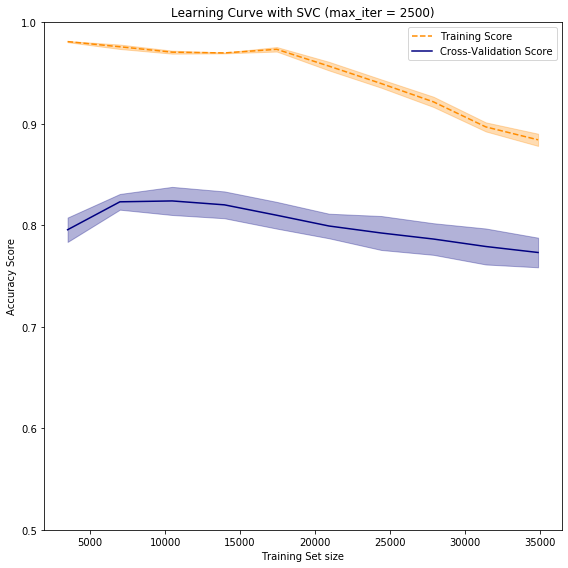

In [41]:
plt.title("Learning Curve with SVC (max_iter = 2500)")
plt.xlabel("Training Set size")
plt.ylabel("Accuracy Score")
plt.ylim(0.5, 1.0)


plt.plot(train_sizes, train_mean, "--", label = "Training Score", color = "darkorange")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha = 0.3, 
                 color = "darkorange")
plt.plot(train_sizes, test_mean, label = "Cross-Validation Score", color = "navy")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha = 0.3, 
                 color = "navy")

plt.legend(loc="best")
plt.tight_layout()
plt.rcParams["figure.figsize"] = (8,8)
plt.savefig('learning_curve_max_iter.png')
plt.show()
